In [48]:
"""
Defines a custom pipeline for imputing missing values in a dataset using the IterativeImputer from scikit-learn.

The pipeline consists of the following steps:
1. Categorical feature encoding using OneHotEncoder
2. Numeric feature scaling using StandardScaler
3. Missing value imputation using IterativeImputer with a BayesianRidge regressor

The `custom_pipe` function returns the complete pipeline, which can be used to fit and transform data.

The `inverse_prep` function can be used to undo the preprocessing steps performed by the pipeline, allowing the original data to be recovered.
"""

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from pandas.api.types import is_list_like
import numpy as np
from time import time
import missingno
import pprint
from autoimpute.imputations import MiceImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Loaded variable 'df' from URI: /home/red/cda_project-1/data/2022_oes_ds_st_indus.csv


# Function to simulate missing values in a dataset
def simulate_missing(data, missing_percentage):
    data_copy = data.copy()
    missing_mask = np.random.rand(*data_copy.shape) < missing_percentage
    data_copy[missing_mask] = np.nan
    return data_copy


def miss_mask(data, missing_percentage):
    data_copy = data.copy()
    missing_mask = np.random.rand(*data_copy.shape) < missing_percentage
    data_copy[missing_mask] = np.nan
    return data_copy


def get_data(path="data/imputation/state_sector_data.csv"):
    """
    Reads a CSV file and returns the data as a pandas DataFrame.

    Parameters:
        path (str): The path to the CSV file. Default is 'data/imputation/state_sector_data.csv'.

    Returns:
        pandas.DataFrame: The data read from the CSV file.
    """
    return pd.read_csv(path)


def get_categories(df, cat_cols):
    """
    Get the unique categories for the specified categorical columns in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the categorical columns.
    cat_cols (list): A list of column names representing the categorical columns.

    Returns:
    list: A list of arrays, where each array contains the unique categories for a categorical column.
    """

    assert is_list_like(cat_cols), "Expected a list of columns"
    assert all([col in df.columns for col in cat_cols]), "key mismatch"

    categories = [df[col].unique() for col in cat_cols]

    return categories


def custom_pipe(df, estimator):
    """
    Create a model pipeline for preprocessing and imputing missing values in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - model (sklearn.pipeline.Pipeline): The model pipeline.

    """

    categorical_columns = df.select_dtypes("object").columns
    numeric_columns = df.select_dtypes("number").columns

    dummy_categories = get_categories(df, categorical_columns)

    scaler = StandardScaler()
    encoder = OneHotEncoder(
        categories=dummy_categories,
        sparse_output=False,
    )

    # Define the preprocessing steps using ColumnTransformer
    preproc = ColumnTransformer(
        transformers=[
            ("cat", encoder, categorical_columns),
            ("num", scaler, numeric_columns),
        ],
        n_jobs=-1,
    )
    imputer = IterativeImputer(
        estimator=estimator,
        initial_strategy="constant",
        # sample_posterior=True,
        fill_value=0,
        min_value=0,
        add_indicator=True,
        max_iter=10,
    )
    # Create the model pipeline
    model = Pipeline(steps=[("prep", preproc), ("impute", imputer)])
    return model


def inverse_prep(model, data):
    """
    Applies inverse transformation to the preprocessed data. In the case of
    the imputation model this was designed for, it converts imputed values
    into the original units.

    Args:
        model (sklearn.pipeline.Pipeline): The fitted pipeline model.
        data (numpy.ndarray): The preprocessed data to be transformed.

    Returns:
        pandas.DataFrame: The inverse transformed data.

    Raises:
        KeyError: If the required steps or transformers are not found in the pipeline.

    """
    prep = model.named_steps["prep"]
    columns = prep.feature_names_in_
    encoder_slicer, scaler_slicer, _ = prep.output_indices_.values()
    encoder = prep.named_transformers_["cat"]
    scaler = prep.named_transformers_["num"]
    encoded_data = data[:, encoder_slicer]
    scaled_data = data[:, scaler_slicer]
    if np.sum(encoded_data.shape) >0:
        inv_encoded_data = encoder.inverse_transform(encoded_data)
        inv_scaled_data = scaler.inverse_transform(scaled_data)
        inv_data = np.c_[inv_encoded_data, inv_scaled_data]

        return pd.DataFrame(data=inv_data, columns=columns)
    elif np.sum(scaled_data.shape) > 0:
        scaler.inverse_transform(scaled_data)
        return pd.DataFrame(data=inv_data, columns=columns)

def stamp():
    return print(f"Time {time():.2f} secs")

In [49]:
df = get_data("data/imputation/state_sector_wide.csv").dropna(axis=1, how="all")

In [50]:
model = custom_pipe(df, BayesianRidge())
pred = model.fit_transform(df)

KeyboardInterrupt: 

In [ ]:
imputed = inverse_prep(data=pred, model=model)


NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

,orig,imp,na
"('state_sector_tot_headcount', 'Agriculture')",NaN,NaN,NaN
"('state_sector_tot_headcount', 'Agriculture')",NaN,NaN,NaN
"('state_sector_tot_headcount', 'Agriculture')",NaN,NaN,NaN


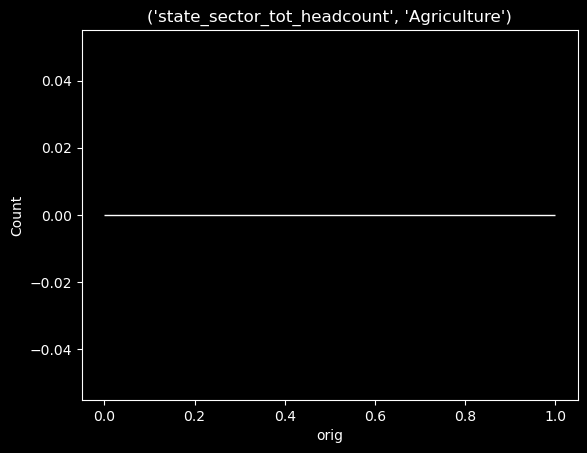

In [14]:
def compare_scatter(x, y):
    title = x.name
    df = pd.DataFrame(data=[x, y, x.isna()], columns=["orig", "imp", "na"])
    display(df.head())
    sns.histplot(data=df, x="orig")
    plt.title(title)

cix = 1
compare_scatter(df.iloc[:, cix], imputed.iloc[:, cix])

0       5800.0
1        210.0
2       9840.0
3       4120.0
4     239210.0
5       2350.0
6        290.0
7        120.0
8          NaN
9      14960.0
10      8910.0
11       520.0
12      4590.0
13      3420.0
14      2120.0
15      3570.0
16      2100.0
17      3480.0
18      3310.0
19      1880.0
20         NaN
21       730.0
22      4990.0
23      3450.0
24      4420.0
25      3350.0
26       970.0
27      1800.0
28       270.0
29       460.0
30      2420.0
31         NaN
32      3100.0
33      5880.0
34       780.0
35      2620.0
36      1860.0
37     13530.0
38      3920.0
39        60.0
40      3930.0
41       720.0
42      1690.0
43     12470.0
44       810.0
45       390.0
46         NaN
47     25990.0
48         NaN
49      4310.0
50       200.0
Name: ('state_sector_tot_headcount', 'Agriculture'), dtype: float64

In [ ]:
# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
stamp()

numeric_cols = df.select_dtypes("number").columns
scoring = {}
og = df.copy()

df = df[~df.isna().any(axis=1)].reset_index(drop=True)

print(f"{df.shape}")

nfolds = 5
score = {}
missingness_levels = [0.05, 0.1, 0.15, 0.2]

In [ ]:
for i in range(nfolds):
    score[i] = {}
    for j in missingness_levels:
        score[i][j] = {}
        for col in numeric_cols:
            score[i][j][col] = None

for i, (train_idx, test_idx) in enumerate(kf.split(df)):
    for missingness in [0.05, 0.1, 0.15, 0.2]:
        x_train = df.loc[train_idx, :].copy()
        x_train[numeric_cols] = simulate_missing(x_train[numeric_cols], 0.1)

        x_test = df.loc[test_idx, :].copy()
        x_test[numeric_cols] = simulate_missing(x_test[numeric_cols], 0.1)

        y_test = df.loc[test_idx, :]
        stamp()
        model.fit(x_train)
        stamp()
        y_pred = inverse_prep(model, model.transform(x_test))

        for col in x_test.loc[:, numeric_cols]:
            mse = mean_squared_error(y_test[col], y_pred[col])
            print(f"{col}: {mse}")
            score[i][missingness][col] = mse

pprint.pp(score)